In [5]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch
import librosa
import librosa.display
import skimage.io

**Preprocessing**

In [46]:
ravdess_emotions = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad',\
                   '05':'angry', '06':'fear', '07':'disgust','08':'surprise'}

In [56]:
processed_data = []
# Folder path of the data 
data_path = 'data/speech-emotion-recognition-ravdess-data/'

# Extracting Label of audio clip from the file name based on the name of the dataset. 
for root, dirs, files in os.walk(data_path):
    for file in files:
        if not file.endswith('.DS_Store'):
            file_path = os.path.join(root, file)
            # Split the file name based on dataset
            emotion = ravdess_emotions[file.split('-')[2]]
            actor = file_path.split('/')[2][-2:]
            
            img_path = get_image_path(file_path)
            #print(emotion)
            processed_data.append([file_path, actor, emotion, img_path])
        
print("All Images Written")
# Compute Recipe Outputs: 
speech_data_processed_df = pd.DataFrame(processed_data, columns=['file_name','actor','emotions','image_path'])

All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image 

All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image 

All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image 

All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image Written
All Image 

In [55]:
def get_image_path(file_path):
    path_list = file_path.split('/')
    img_path = path_list[-1]
    
     # settings
    hop_length = 512 # number of samples per time-step in spectrogram
    n_mels = 128 # number of bins in spectrogram. Height of image
    time_steps = 384 # number of time-steps. Width of image

    # load audio. Using example from librosa
    y, sr = librosa.load(file_path, offset=1.0, duration=10.0, sr=22050)
    out = img_path[:-4] + '.png'

    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]
    
    # convert to PNG
    #spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    #print('wrote file', out)
    
    return out

In [54]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

In [126]:
speech_data_processed_df.head(60)

,file_name,actor,emotions,image_path
0,data/speech-emotion-recognition-ravdess-data/A...,16,angry,03-01-05-01-02-01-16.png
1,data/speech-emotion-recognition-ravdess-data/A...,16,fear,03-01-06-01-02-02-16.png
2,data/speech-emotion-recognition-ravdess-data/A...,16,fear,03-01-06-02-01-02-16.png
3,data/speech-emotion-recognition-ravdess-data/A...,16,angry,03-01-05-02-01-01-16.png
4,data/speech-emotion-recognition-ravdess-data/A...,16,disgust,03-01-07-01-01-01-16.png
5,data/speech-emotion-recognition-ravdess-data/A...,16,sad,03-01-04-01-01-02-16.png
6,data/speech-emotion-recognition-ravdess-data/A...,16,sad,03-01-04-02-02-02-16.png
7,data/speech-emotion-recognition-ravdess-data/A...,16,disgust,03-01-07-02-02-01-16.png
8,data/speech-emotion-recognition-ravdess-data/A...,16,surprise,03-01-08-02-02-01-16.png
9,data/speech-emotion-recognition-ravdess-data/A...,16,surprise,03-01-08-01-01-01-16.png


In [41]:
speech_data_processed_df.file_name[0]

'data/speech-emotion-recognition-ravdess-data/Actor_16/03-01-05-01-02-01-16.wav'

In [122]:
speech_data_processed_df.groupby('emotions').count()

,file_name,actor,image_path
emotions,,,
angry,192,192,192
calm,192,192,192
disgust,192,192,192
fear,192,192,192
happy,192,192,192
neutral,96,96,96
sad,192,192,192
surprise,192,192,192


In [131]:
pd.set_option('display.width', 2000)

In [132]:
speech_data_processed_df[speech_data_processed_df.actor == '08']

,file_name,actor,emotions,image_path
1380,data/speech-emotion-recognition-ravdess-data/A...,08,surprise,03-01-08-01-02-01-08.png
1381,data/speech-emotion-recognition-ravdess-data/A...,08,surprise,03-01-08-02-01-01-08.png
1382,data/speech-emotion-recognition-ravdess-data/A...,08,disgust,03-01-07-02-01-01-08.png
1383,data/speech-emotion-recognition-ravdess-data/A...,08,sad,03-01-04-02-01-02-08.png
1384,data/speech-emotion-recognition-ravdess-data/A...,08,sad,03-01-04-01-02-02-08.png
1385,data/speech-emotion-recognition-ravdess-data/A...,08,disgust,03-01-07-01-02-01-08.png
1386,data/speech-emotion-recognition-ravdess-data/A...,08,angry,03-01-05-02-02-01-08.png
1387,data/speech-emotion-recognition-ravdess-data/A...,08,fear,03-01-06-02-02-02-08.png
1388,data/speech-emotion-recognition-ravdess-data/A...,08,fear,03-01-06-01-01-02-08.png
1389,data/speech-emotion-recognition-ravdess-data/A...,08,angry,03-01-05-01-01-01-08.png


In [108]:
np.random.seed(3)
train_size = 0.6
validate_size = 0.2
train, validate, test = np.split(speech_data_processed_df.sample(frac=1), [int(train_size * len(speech_data_processed_df)), int((validate_size + train_size) * len(speech_data_processed_df))])

In [115]:
#train, validate, test

**Acoustic Feature Extraction**

In [42]:
import wave

In [43]:
sf_filewave = wave.open('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav')
signal_sf = sf_filewave.readframes(-1)

# Convert audio bytes to integers
soundwave_sf = np.frombuffer(signal_sf, dtype='int16')

# Get the sound wave frame rate 
framerate_sf = sf_filewave.getframerate()

# Find the sound wave timestamps 
time_sf = np.linspace(start=0, stop=len(soundwave_sf)/framerate_sf, num=len(soundwave_sf))

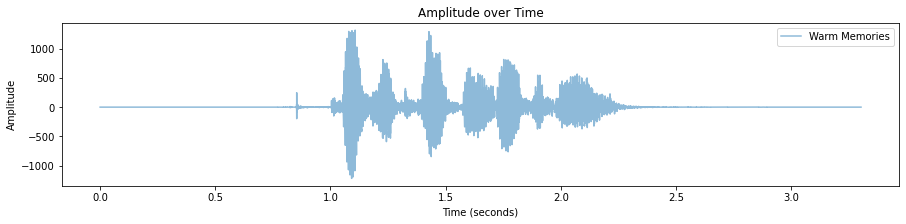

In [44]:
fig, ax = plt.subplots(figsize=(15,3))

# Setup the title and axis titles
plt.title('Amplitude over Time')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
# Add the audio data to the plot
ax.plot(time_sf, soundwave_sf, label='Warm Memories', alpha=0.5)
plt.legend()
plt.show()

In [45]:
def extract_features(X, sample_rate): 
    result = np.array([])
    
    # Mel Spectrogram: 
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    
    return result 

In [46]:
#extract_features(X, 60)

In [68]:
x, sr = librosa.load('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-02-01.wav', offset=1.0, duration=10.0, sr=22050)

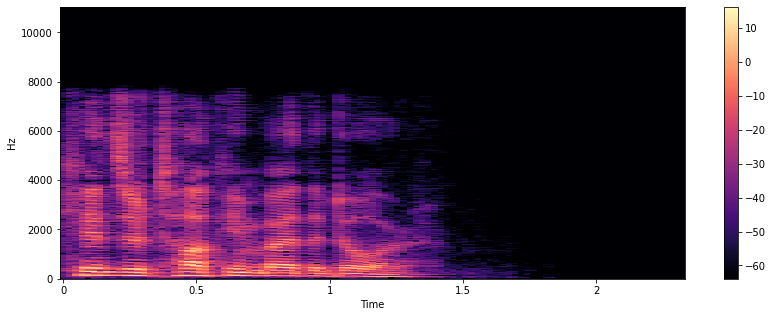

In [69]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

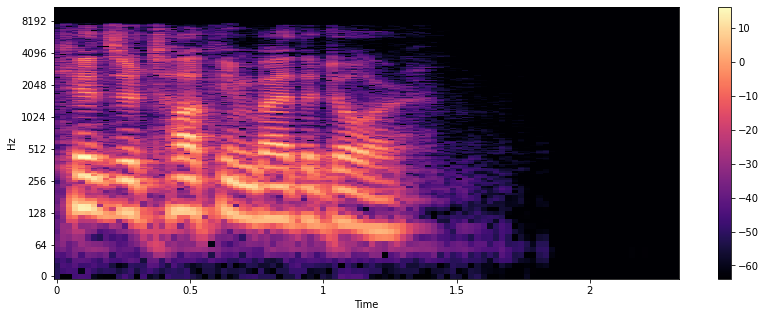

In [70]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

**PreProcessing**

**Files should look like:**\
data path, actor code, emotion, train/val/test

**dataset, dataloader**
--> x,y (x 1 image, 8 images)  --> Image: Tensor X: [batch_size,1,H,W] Y: [batch_size, 8, H, W]

GAN: 1 image to all other images
Loss: 6 Predicted vs 6 Actual [for that actor] 


1 Emotion translate to all other emotions 